<a href="https://colab.research.google.com/github/bhavini-jeloka/sc627-mpc/blob/main/SC627_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SC627: Path Planning and Coordination of Autonomous Vehicles

In the following code, we implement the paper "Model Predictive Control for Autonomous Driving considering Actuator Dynamics" by Mithun Babu et. al. 

It focuses on an ego vehicle using alternating optimization and taking into account the actuator dynamics.

## Installing the required packages

In [1]:
import numpy as np
import math
from scipy.optimize import minimize
import copy
from functools import partial
from scipy.optimize import NonlinearConstraint
import matplotlib.pyplot as plt
import time

## Creating a class to implement alternating optimization

In [2]:
class VehicleDynamics:

  def __init__(self):
    self.obstacle = [[0,1], [-1,1], [1,-1]] # locations of the obstacles
    self.R = [0.3, 0.5, 1] # relative radii of the obstacles
    self.wTheta = 1
    self.wV = 1
    self.epsilon = 0.1
    self.kappaMax = 10
    self.delta = 0.1
    self.stepSize = 0.02
    self.timeConstant = 0.01
    self.thetaDotMin = 0
    self.thetaDotMax = 5
    self.thetaDoubleDotMin = 0
    self.thetaDoubleDotMax = 5
    self.thetaTrust = 0.01
    self.vMax = 25
    self.aMin = -6
    self.aMax = 4
    self.currentTime = 0  # iteration number 
    self.maxIter= 1000

    self.vel = np.zeros(self.maxIter)
    self.state = np.zeros((self.maxIter, 4))
    self.thetaDoubleDot = np.zeros(self.maxIter)
    self.v_cmd = np.zeros(self.maxIter)


  def updateLaw(self, u1, u2):  # updating the dynamics

      # u1 = commanded angular acceleration
      # u2 = commanded linear velocity
      t= self.currentTime
      self.thetaDoubleDot[t] = u1
      self.v_cmd[t]= u2 
      v_prev = 0
      if t>0:
        v_prev = self.vel[t-1]

      self.vel[t] = u2 + ((v_prev - u2)* math.exp(-self.stepSize/self.timeConstant))  # actuator dynamics
      self.state[t+1][3]= self.state[t][3] + (u1 *  self.stepSize)
      self.state[t+1][2]= self.state[t][2] + (self.state[t][3] * self.stepSize) + (0.5 * u1 * self.stepSize * self.stepSize)
      self.state[t+1][1]= self.state[t][1] + (self.vel[t] * np.sin(self.state[t][2]) * self.stepSize)
      self.state[t+1][0]= self.state[t][0] + (self.vel[t] * np.cos(self.state[t][2]) * self.stepSize)

  '''
  Setting up the optimization problem for the Angular Acceleration
  '''

# Cost function
  def thetaCost(self, vec): # vec = [thetaDDot, sTheta]
    thetaDDot_t = vec[0]
    sTheta = vec[1] 
    return thetaDDot_t**2 + self.wTheta*sTheta

# Constraints

  def cObst(self, v_cmd_con, x_hat, y_hat, i, u1):
      cHatObs =  - (x_hat-self.obstacle[i][0])**2 - (y_hat-self.obstacle[i][1])**2 + self.R[i]**2
      u2= v_cmd_con
      vel = u2 + ((self.vel[self.currentTime-1] - u2)* math.exp(-self.stepSize/self.timeConstant))
      thetaDot = self.state[self.currentTime, 3] + (u1 *  self.stepSize)
      theta = self.state[self.currentTime, 2] + (self.state[self.currentTime, 3] * self.stepSize) + (0.5 * u1 * self.stepSize * self.stepSize)
      x = self.state[self.currentTime, 0] + vel* np.cos(self.state[self.currentTime, 2]) * self.stepSize
      y = self.state[self.currentTime, 1] + vel* np.sin(self.state[self.currentTime, 2]) * self.stepSize

      Delta_x= - 2 * (x_hat - self.obstacle[i][0]) 
      Delta_y= -2 * (y_hat - self.obstacle[i][1])

      return cHatObs + (Delta_x)*(x- x_hat) + (Delta_y)*(y - y_hat)
      
  def thetaConstraint1(self, vec):
      return self.state[self.currentTime, 3] + self.stepSize*vec[0]

  def thetaConstraint2(self, vec):
      return vec[0]

  def thetaConstraint3a(self, v_cmd_con, x_hat, y_hat, vec):
      return self.cObst(v_cmd_con, x_hat, y_hat, 0, vec[0])-vec[1]

  def thetaConstraint3b(self, v_cmd_con, x_hat, y_hat, vec):
      return self.cObst(v_cmd_con, x_hat, y_hat, 1, vec[0])-vec[1]

  def thetaConstraint3c(self, v_cmd_con, x_hat, y_hat, vec):
      return self.cObst(v_cmd_con, x_hat, y_hat, 2, vec[0])-vec[1]

  def thetaConstraint4(self, vec):
      return vec[1]

  def thetaConstraint5(self, vec):
      return self.state[self.currentTime, 2] + self.stepSize*self.state[self.currentTime, 3] + 0.5*vec[0]*(self.stepSize**2)

  '''
  Setting up the optimization problem for the Commanded Velocity
  '''

# Cost function
  def vCost(self, var):
    v_cmd_t = var[0]
    sV = var[1] 

    v_cmd_t_1 = 0 
    v_cmd_t_2 = 0
    if self.currentTime > 0:
      v_cmd_t_1 = self.v_cmd[self.currentTime-1]
      if self.currentTime > 1:
        v_cmd_t_2 = self.v_cmd[self.currentTime-2]
    
    jV = (v_cmd_t_2 + v_cmd_t - 2*v_cmd_t_1)**2/(self.stepSize**4)
    return jV + self.wV*sV

# Without the slack variable
  def vCostTerm1(self, v_cmd_t):
    v_cmd_t_1 = 0 
    v_cmd_t_2 = 0
    if self.currentTime > 0:
      v_cmd_t_1 = self.v_cmd[self.currentTime-1]
      if self.currentTime > 1:
        v_cmd_t_2 = self.v_cmd[self.currentTime-2]
    jV = (v_cmd_t_2 + v_cmd_t - 2*v_cmd_t_1)**2/(self.stepSize**4)
    return jV


# Constraints

  def cObst2(self, thetaDDot_con, x_hat, y_hat, i, u2):
    cHatObs =  - (x_hat-self.obstacle[i][0])**2 - (y_hat-self.obstacle[i][1])**2 + self.R[i]**2
    u1 = thetaDDot_con 
    vel = u2 + ((self.vel[self.currentTime-1] - u2)* math.exp(-self.stepSize/self.timeConstant))
    thetaDot = self.state[self.currentTime][3] + (u1 *  self.stepSize)
    theta = self.state[self.currentTime][2] + (self.state[self.currentTime][3] * self.stepSize) + (0.5 * u1 * self.stepSize * self.stepSize)
    x = self.state[self.currentTime][0] + vel* np.cos(self.state[self.currentTime][2]) * self.stepSize
    y = self.state[self.currentTime][1] + vel* np.sin(self.state[self.currentTime][2]) * self.stepSize

    Delta_x= - 2 * (x_hat - self.obstacle[i][0]) 
    Delta_y= -2 * (y_hat - self.obstacle[i][1])

    return cHatObs + (Delta_x)*(x- x_hat) + (Delta_y)*(y - y_hat)
      
  def vConstraint1(self, var):
    return var[0]

  def vConstraint2(self, var):
    v_cmd_t_1 = 0 
    if self.currentTime > 0:
      v_cmd_t_1 = self.v_cmd[self.currentTime-1]

    return (var[0]-v_cmd_t_1)/self.stepSize
  
  def vConstraint3a(self, thetaDDot_con, x_hat, y_hat, var):
    return self.cObst2(thetaDDot_con, x_hat, y_hat, 0, var[0])-var[1]

  def vConstraint3b(self, thetaDDot_con, x_hat, y_hat, var):
    return self.cObst2(thetaDDot_con, x_hat, y_hat, 1, var[0])-var[1]

  def vConstraint3c(self, thetaDDot_con, x_hat, y_hat, var):
    return self.cObst2(thetaDDot_con, x_hat, y_hat, 2, var[0])-var[1]

  def vConstraint4(self, var):
    vel_t_1 = 0 
    if self.currentTime > 0:
      vel_t_1 = self.vel[self.currentTime-1]
    vel = var[0] + ((vel_t_1 - var[0])* math.exp(-self.stepSize/self.timeConstant))

    return vel

  def vConstraint5(self, var):
      return var[1]

  '''
  Defining the MPC solver using alternating optimization for a single time step
  '''

# MPC solver
  def alternatingMPC(self, thetaDDotHat, v_cmdHat): # inital guesss of the values

    k = 0
    jTheta_prev = 0
    jTheta_current = thetaDDotHat

    v_cmd_prev = 0
    v_cmd_current = v_cmdHat



    while k==0 or (np.abs(jTheta_current**2 - jTheta_prev**2) > self.epsilon and (self.vCostTerm1(v_cmd_current)-self.vCostTerm1(v_cmd_prev)) > self.epsilon):

      vel = v_cmd_current + ((self.vel[self.currentTime-1] - v_cmd_current)* math.exp(-self.stepSize/self.timeConstant))
      xHat = self.state[self.currentTime][0] + vel* np.cos(self.state[self.currentTime][2]) * self.stepSize
      yHat = self.state[self.currentTime][1] + vel* np.sin(self.state[self.currentTime][2]) * self.stepSize

      theta_prev = self.state[self.currentTime-1, 2] + (self.state[self.currentTime-1, 3] * self.stepSize) + (0.5 * jTheta_prev * self.stepSize * self.stepSize)
     
      thetaConstraint3a_partial = partial(self.thetaConstraint3a, v_cmd_current, xHat, yHat)
      thetaConstraint3b_partial = partial(self.thetaConstraint3b, v_cmd_current, xHat, yHat)
      thetaConstraint3c_partial = partial(self.thetaConstraint3c, v_cmd_current, xHat, yHat)
      
      thetaConstraint1_NLC = NonlinearConstraint(self.thetaConstraint1, self.thetaDotMin, self.thetaDotMax)
      thetaConstraint2_NLC = NonlinearConstraint(self.thetaConstraint2, self.thetaDoubleDotMin, self.thetaDoubleDotMax)
      thetaConstraint3a_NLC = NonlinearConstraint(thetaConstraint3a_partial, -np.inf, 0)
      thetaConstraint3b_NLC = NonlinearConstraint(thetaConstraint3b_partial, -np.inf, 0)
      thetaConstraint3c_NLC = NonlinearConstraint(thetaConstraint3c_partial, -np.inf, 0)
      thetaConstraint4_NLC = NonlinearConstraint(self.thetaConstraint4, 0, np.inf)
      thetaConstraint5_NLC = NonlinearConstraint(self.thetaConstraint5, theta_prev-self.thetaTrust, theta_prev+self.thetaTrust) 
      thetaConstraint6_NLC = NonlinearConstraint(self.thetaConstraint1, -self.kappaMax* v_cmd_current, self.kappaMax*v_cmd_current)


      thetaResult = minimize(self.thetaCost, [jTheta_current, 0], method='trust-constr', constraints=[thetaConstraint1_NLC, thetaConstraint2_NLC, thetaConstraint3a_NLC,
                                                                                 thetaConstraint3b_NLC, thetaConstraint3c_NLC, thetaConstraint4_NLC,
                                                                                 thetaConstraint5_NLC, thetaConstraint6_NLC])

      jTheta_prev = copy.copy(jTheta_current)
      jTheta_current = copy.copy(thetaResult.x[0])

      for i in range(3):
        if self.cObst(v_cmdHat, xHat, yHat, i, jTheta_current)>self.epsilon:
          self.wTheta = self.wTheta*self.delta
          break


      vConstraint3a_partial = partial(self.vConstraint3a, jTheta_current, xHat, yHat)
      vConstraint3b_partial = partial(self.vConstraint3b, jTheta_current, xHat, yHat)
      vConstraint3c_partial = partial(self.vConstraint3c, jTheta_current, xHat, yHat)

      vConstraint1_NLC = NonlinearConstraint(self.vConstraint1, -self.vMax, self.vMax)
      vConstraint2_NLC = NonlinearConstraint(self.vConstraint2, self.aMin, self.aMax)
      vConstraint3a_NLC = NonlinearConstraint(vConstraint3a_partial, -np.inf, 0)
      vConstraint3b_NLC = NonlinearConstraint(vConstraint3b_partial, -np.inf, 0)
      vConstraint3c_NLC = NonlinearConstraint(vConstraint3c_partial, -np.inf, 0)
      vConstraint4_NLC = NonlinearConstraint(self.vConstraint4, np.abs(self.state[self.currentTime, 3] + ( jTheta_current*  self.stepSize))/self.kappaMax, np.inf)
      vConstraint5_NLC = NonlinearConstraint(self.vConstraint5, 0, np.inf) 
      

      v_cmdResult = minimize(self.vCost, [v_cmd_current, 0], method='trust-constr', constraints=[vConstraint1_NLC, vConstraint2_NLC, vConstraint3a_NLC,
                                                                                 vConstraint3b_NLC, vConstraint3c_NLC, vConstraint4_NLC,
                                                                                 vConstraint5_NLC])

      v_cmd_prev = copy.copy(v_cmd_current)
      v_cmd_current = copy.copy(v_cmdResult.x[0])

      for i in range(3):
        if self.cObst(v_cmd_current, xHat, yHat, i, jTheta_current)>self.epsilon:
          self.wV = self.wV*self.delta
          break


      k = k+1
  
      return [jTheta_current, v_cmd_current]

  '''
  Implementing MPC over a time horizon
  '''

  def timeLoop(self):

    v_cmd_guess0= 0 
    jThetaDdot_guess= 0 

    for time in range(self.maxIter-1):
      u1, u2 = self.alternatingMPC(jThetaDdot_guess, v_cmd_guess0)

      self.thetaDoubleDot[self.currentTime] = u1
      self.v_cmd[self.currentTime] = u2

      self.updateLaw(u1, u2)

      self.currentTime= self.currentTime + 1

      jThetaDdot_guess = u1
      v_cmd_guess0 = u2
    return self.state[:, 0], self.state[:, 1], self.vel, self.thetaDoubleDot, self.v_cmd

## Creating a class to implement joint optimization

In [3]:
class VehicleDynamics_NonAlternating:

  def __init__(self):
    self.obstacle = [[0,1], [-1,1], [1,-1]]
    self.R = [0.3, 0.5, 1] # relative radii 
    self.wTheta = 1
    self.wV = 1
    self.epsilon = 0.1
    self.kappaMax = 10
    self.delta = 0.1
    self.stepSize = 0.02
    self.timeConstant = 0.01
    self.thetaDotMin = 0
    self.thetaDotMax = 5
    self.thetaDoubleDotMin = 0
    self.thetaDoubleDotMax = 5
    self.thetaTrust = 0.01
    self.vMax = 25
    self.aMin = -6
    self.aMax = 4
    self.currentTime = 0  # Iteration number and not time
    self.maxIter= 60 # n+1

    self.vel = np.zeros(self.maxIter)
    self.state = np.zeros((self.maxIter, 4))
    self.thetaDoubleDot = np.zeros(self.maxIter)
    self.v_cmd = np.zeros(self.maxIter)


  def updateLaw(self, u1, u2):

      # u1 = commanded angular acceleration
      # u2 = commanded linear velocity
      t= self.currentTime
      self.thetaDoubleDot[t] = u1
      self.v_cmd[t]= u2 
      v_prev = 0
      if t>0:
        v_prev = self.vel[t-1]

      self.vel[t] = u2 + ((v_prev - u2)* math.exp(-self.stepSize/self.timeConstant))
      self.state[t+1][3]= self.state[t][3] + (u1 *  self.stepSize)
      self.state[t+1][2]= self.state[t][2] + (self.state[t][3] * self.stepSize) + (0.5 * u1 * self.stepSize * self.stepSize)
      self.state[t+1][1]= self.state[t][1] + (self.vel[t] * np.sin(self.state[t][2]) * self.stepSize)
      self.state[t+1][0]= self.state[t][0] + (self.vel[t] * np.cos(self.state[t][2]) * self.stepSize)


  def J_theta(self, thetaDdot):
    sum= 0
    for i in range(self.currentTime):
      sum= sum + (self.thetaDoubleDot[i]**2)
    sum = sum + (thetaDdot **2)

    return thetaDdot

  def J_vc(self, v_c):

    sum= 0

    vc_t_1= 0
    vc_t_2= 0

    for i in range(self.currentTime):
      if (i>0):
        vc_t_1= self.v_cmd[i-1]
        if (i>1):
          vc_t_2= self.v_cmd[i-2]

      sum = sum + ((vc_t_2 + self.v_cmd[i] - 2* vc_t_1)**2/self.stepSize**4)

    if (self.currentTime>0):
        vc_t_1= self.v_cmd[self.currentTime-1]
        if (i>1):
          vc_t_2= self.v_cmd[self.currentTime-2]

    sum = sum + ((vc_t_2 + v_c - 2* vc_t_1)**2/self.stepSize**4)

    return sum

  def Jsmooth(self, vec):

    thetaDdot= vec[0]
    v_c= vec[1]
    Cost= self.J_theta(thetaDdot) + self.J_vc(v_c)

    return Cost

  def Constraint1(self, vec):
    return self.state[self.currentTime][3] + self.stepSize*vec[0]

  def Constraint2(self, vec):
    return vec[0]

  def Constraint3(self, vec):
    return vec[1]

  def Constraint4(self, vec):
    return (vec[1] - self.vel[self.currentTime-1])/self.stepSize

  def cObst2(self, vec, i):

      u1= vec[0]
      u2= vec[1]
      vel = u2 + ((self.vel[self.currentTime-1] - u2)* math.exp(-self.stepSize/self.timeConstant))
      thetaDot = self.state[self.currentTime][3] + (u1 *  self.stepSize)
      theta = self.state[self.currentTime][2] + (self.state[self.currentTime][3] * self.stepSize) + (0.5 * u1 * self.stepSize * self.stepSize)
      x = self.state[self.currentTime][0] + vel* np.cos(self.state[self.currentTime][2]) * self.stepSize
      y = self.state[self.currentTime][1] + vel* np.sin(self.state[self.currentTime][2]) * self.stepSize

      return -(x - self.obstacle[i][0])**2 - (y- self.obstacle[i][1])**2 + self.R[i]**2

  def Constraint5a(self, vec):
    return self.cObst2(vec, 0)

  def Constraint5b(self, vec):
    return self.cObst2(vec, 1)

  def Constraint5c(self, vec):
    return self.cObst2(vec, 2)

  def ActuatorModel(self, vc):
    return vc + (self.vel[self.currentTime-1] - vc)*math.exp(-self.stepSize/self.timeConstant)



  def timeloop(self):

    Constraint1_NLC = NonlinearConstraint(self.Constraint1, self.thetaDotMin, self.thetaDotMax)
    Constraint2_NLC = NonlinearConstraint(self.Constraint2, self.thetaDoubleDotMin, self.thetaDoubleDotMax)
    Constraint3_NLC = NonlinearConstraint(self.Constraint3, -self.vMax,self.vMax)
    Constraint4_NLC = NonlinearConstraint(self.Constraint4, self.aMin, self.aMax)
    Constraint5a_NLC = NonlinearConstraint(self.Constraint5a, -np.inf, 0)
    Constraint5b_NLC = NonlinearConstraint(self.Constraint5b, -np.inf, 0)
    Constraint5c_NLC = NonlinearConstraint(self.Constraint5c, -np.inf, 0) 

    vec_current= [0, 0]

    for i in range(self.maxIter-1):

      Result = minimize(self.Jsmooth, vec_current, method='trust-constr', constraints=[Constraint1_NLC, Constraint2_NLC, Constraint3_NLC,
                                                                                  Constraint4_NLC, Constraint5a_NLC, Constraint5b_NLC,
                                                                                  Constraint5c_NLC])
    
      vec_current = Result.x

      self.thetaDoubleDot[self.currentTime]= vec_current[0]
      self.v_cmd[self.currentTime]= vec_current[1]

      self.updateLaw(vec_current[0], vec_current[1])
      self.currentTime= self.currentTime + 1
    return self.state[:, 0], self.state[:, 1], self.vel, self.thetaDoubleDot, self.v_cmd

## Deploying the optimization models

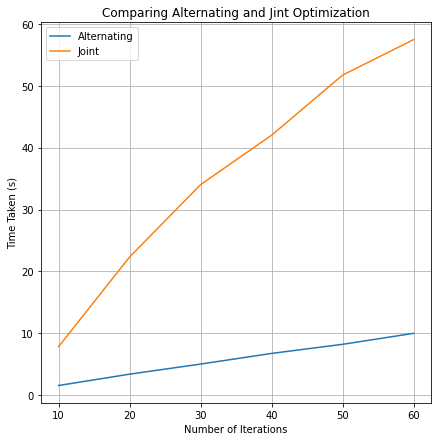

In [5]:
if __name__ == '__main__':

  print("Starting Alternating Optimization")
  start_time1 = time.time()
  car = VehicleDynamics()
  results = car.timeLoop()
  end_time1 = time.time()-start_time1
  print(end_time1)

  print("Starting Joint Optimization")
  start_time2 = time.time()
  car_NonAlternating = VehicleDynamics_NonAlternating()
  results_NonAlternating = car_NonAlternating.timeLoop()
  end_time2 = time.time() - start_time2
  print(end_time2)
  